In [1]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
import torch.utils.checkpoint as checkpoint
import torch.utils.data

import matplotlib.pyplot as plt

from torchvision.io import read_image

import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset

import torchvision.transforms.functional

from PIL import Image

from sklearn import preprocessing
import SimpleITK as sitk

In [2]:
class MedNeXt_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, expansion_ratio):
        super(MedNeXt_block, self).__init__()
        # Depthwise convolution layer
        stride = 1
        if in_channels != out_channels: stride = 2
        self.depthwise_conv = nn.Conv3d(in_channels, out_channels = in_channels, stride = stride,
                                        kernel_size=kernel_size, padding = (kernel_size - 1) // 2)
        
        self.depthwise_transpose = nn.ConvTranspose3d(in_channels, out_channels = in_channels,
                                                      stride = stride, kernel_size=kernel_size,
                                                      padding = (kernel_size - stride) // 2 + 1)

        self.group_norm = nn.GroupNorm(num_groups=in_channels, num_channels=in_channels)

        # Expansion layer
        self.expansion_conv = nn.Conv3d(in_channels, in_channels * expansion_ratio, 
                              kernel_size = 1)
        self.activation = nn.GELU()

        # Compression layer
        self.compression_conv = nn.Conv3d(in_channels * expansion_ratio, out_channels,
                              kernel_size = 1)
        
        # Residuals
        self.conv = nn.Conv3d(in_channels, out_channels, stride = 2, kernel_size = 1)
        self.conv_transpose = nn.ConvTranspose3d (in_channels, out_channels, stride = 2,
                                                  kernel_size = 1)
        
        self.ratio = out_channels/in_channels

    def forward(self, x):
        if self.ratio == 0.5: out = self.depthwise_transpose(x)
        else: out = self.depthwise_conv(x)
        
        #print ("dw", out.shape)
        out = self.group_norm(out)
        #print ("grp norm", out.shape)
        out = self.expansion_conv(out)
        #print ("exp", out.shape)
        out = self.activation(out)
        out = self.compression_conv(out)
        #print ("comp", out.shape)
        
        residual = x
        #print(residual.shape)
        #print("final", out.shape)
        if self.ratio == 2: 
            residual = self.conv(x)
        elif self.ratio == 0.5:
            residual = self.conv_transpose(x)
        #print("resid", residual.shape)
        return out + residual

In [3]:
class MedNeXt_s(nn.Module):
    def __init__(self, in_channels):
        super(MedNeXt_s, self).__init__()
        R = 2 # the expansion ratio
        self.block1 = MedNeXt_block(in_channels, in_channels, 5, R)
        self.encoder1 = MedNeXt_block(in_channels, in_channels*2, 5, R)
        self.block2 = MedNeXt_block(in_channels*2, in_channels*2, 5, R)
        self.encoder2 = MedNeXt_block(in_channels*2, in_channels*4, 5, R)

        self.bottleneck = MedNeXt_block(in_channels*4, in_channels*4, 5, R)

        self.decoder1 = MedNeXt_block(in_channels*4, in_channels*2, 5, R)
        self.block3 = MedNeXt_block(in_channels*2, in_channels*2, 5, R)
        self.decoder2 = MedNeXt_block(in_channels*2, in_channels, 5, R)
        self.block4 = MedNeXt_block(in_channels, in_channels, 5, R)

    def forward (self, x):
        out1 = self.block1(x)
        out2 = self.encoder1(out1)
        out2 = self.block2(out2)
        out3 = self.encoder2(out2)
        out3 = self.bottleneck(out3)
        out3 = self.decoder1(out3)
        #print (out3.shape, out2.shape)
        out = self.block3(out3 + out2[:, :, :119, :119, :77])
        out = self.decoder2(out)
        #print (out.shape, out1.shape)
        out = self.block4 (out + out1[:, :, :237, :237, :153])
        return nn.Softmax(dim=1)(out)

In [4]:
sample_input = torch.randn([4, 240, 240, 155]).unsqueeze(dim = 0)
block = MedNeXt_s(4)
block(sample_input).shape

torch.Size([1, 4, 237, 237, 153])

In [5]:
def plot_image (np_arr, sizex = 6, sizey = 6):
    fig, ax = plt.subplots(figsize=(sizex, sizey))
    ax.imshow(np_arr, cmap='gray')
    plt.show()

In [6]:
"""
0: Background - This class represents the healthy brain tissue and is the majority class in the dataset.
1: Necrosis and Non-Enhancing Tumor - This class represents the non-enhancing tumor and the necrotic core of the enhancing tumor.
2: Edema - This class represents the edema surrounding the tumor.
3: Enhancing Tumor - This class represents the enhancing tumor."""

class BraTS2021Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.patient_ids = os.listdir(data_dir)

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        scan_files = [os.path.join(self.data_dir, patient_id, f'{patient_id}_{modality}.nii.gz')
                      for modality in ['t1', 't2', 't1ce', 'flair']]
        mask_file = os.path.join(self.data_dir, patient_id, f'{patient_id}_seg.nii.gz')

        # Load scan files and concatenate into a 4-channel tensor
        # In the BraTS dataset specifically, each patient has four MRI scans available: 
        # T1-weighted, T1-weighted with contrast enhancement (T1ce), T2-weighted, and FLAIR. 
        # By concatenating these four scans into a single 4-channel tensor, we can provide 
        # the model with more information about the anatomy being imaged.
        
        scans = []
        for scan_file in scan_files:
            scan_data = nib.load(scan_file).get_fdata()
            scans.append(scan_data)
        scans_tensor = np.stack(scans, axis=0)
        
        # Load mask file and convert to integer labels
        mask_data = nib.load(mask_file).get_fdata()
        mask_tensor = (mask_data > 0).astype(np.int64) + (mask_data == 4).astype(np.int64) * 2
        
        # Normalize scans and convert to PyTorch tensor
        scans_tensor -= np.mean(scans_tensor)
        scans_tensor /= np.std(scans_tensor)
        scans_tensor = torch.from_numpy(scans_tensor).float()
        
        # Convert mask to PyTorch tensor
        mask_tensor = torch.from_numpy(mask_tensor).long()
        
        return scans_tensor, mask_tensor

Scan tensor shape: torch.Size([4, 240, 240, 155])
Mask tensor shape: torch.Size([240, 240, 155])


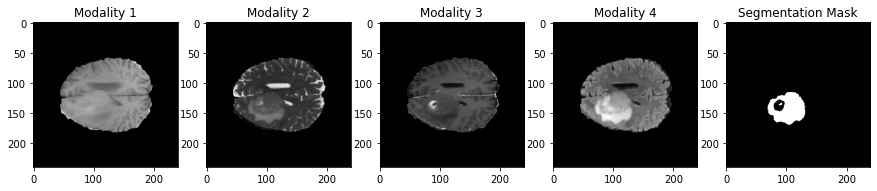

In [7]:
# Test the dataset

data_dir = 'C:/Users/alist/WorkCodes/Datasets/BRATS2021TRAINDATASET'
dataset = BraTS2021Dataset(data_dir)

# Load a single patient's MRI scan and segmentation mask
patient_idx = 1
scan, mask = dataset[patient_idx]

new_tensor = torch.zeros_like(mask) # Initialize new tensor with all zeros
new_tensor[mask == 1] = 1 
mask = new_tensor

# Print shape of scan and mask tensors
print('Scan tensor shape:', scan.shape)
print('Mask tensor shape:', mask.shape)

# Visualize the scan and mask using matplotlib
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(4):
    axs[i].imshow(scan[i][:, :, 100], cmap='gray')
    axs[i].set_title(f'Modality {i+1}')
axs[4].imshow(mask[:, :, 100], cmap='gray')
axs[4].set_title('Segmentation Mask')
plt.show()

In [8]:
import torch.utils.data

# Define split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the whole dataset into train and test dataset. Is validation needed?
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
model = MedNeXt_s(4).to(device)

In [10]:
def Dice(output, target, eps=1e-5):
        target = target.float()
        num = 2 * (output * target).sum()
        den = output.sum() + target.sum() + eps
        return 1.0 - num/den

class softmax_dice(nn.Module):
    '''
    The dice loss for using softmax activation function
    :param output: (b, num_class, d, h, w)
    :param target: (b, d, h, w)
    :return: softmax dice loss
    '''
    def __init__(self):
        super(softmax_dice, self).__init__()
        
    def forward(self, output, target):
        target[target == 4] = 3 
        output = output.cuda()
        target = target.cuda()
        loss0 = Dice(output[:, 0, ...], (target == 0).float())
        loss1 = Dice(output[:, 1, ...], (target == 1).float())
        loss2 = Dice(output[:, 2, ...], (target == 2).float())
        loss3 = Dice(output[:, 3, ...], (target == 3).float())

        return loss1 + loss2 + loss3 + loss0 #, 1-loss1.data, 1-loss2.data, 1-loss3.data

In [12]:
# Define hyperparameters
learning_rate = 0.001
num_epochs = 2

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

# Define loss function and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = softmax_dice()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Load checkpoint ==============================
#checkpoint = torch.load('checkpoint.pth')

# Extract relevant data from checkpoint
#epoch = checkpoint['epoch']
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#loss = checkpoint['loss']
# ==============================================

softmax = nn.Softmax(dim = 1)

model.train()

running_loss = 0

for epoch in range(num_epochs):
    
    running_loss = 0.0
    totalTestLoss = 0

    model.train()

    for counter, (images, labels) in enumerate(train_loader):
        outputs = model(images.cuda())
        loss = criterion(outputs, labels[:, :237, :237, :153].long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # print("running_loss", loss.item())
        
        if counter % 20 == 19:
            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            },  'checkpoint-'+ str(epoch) +'.pth')
            print( "epoch:", epoch, "iteration:", counter, "Average cost function", running_loss/20)
            running_loss = 0

epoch: 0 iteration: 19 Average cost function 2.9150975346565247
epoch: 0 iteration: 39 Average cost function 2.849051523208618
epoch: 0 iteration: 59 Average cost function 2.677761697769165
epoch: 0 iteration: 79 Average cost function 2.440603053569794
epoch: 0 iteration: 99 Average cost function 2.3695252895355225
epoch: 0 iteration: 119 Average cost function 2.3008860468864443
epoch: 0 iteration: 139 Average cost function 2.231439232826233
epoch: 0 iteration: 159 Average cost function 2.2445858836174013
epoch: 0 iteration: 179 Average cost function 2.0919848024845122
epoch: 0 iteration: 199 Average cost function 2.100735145807266
epoch: 0 iteration: 219 Average cost function 2.2053944766521454
epoch: 0 iteration: 239 Average cost function 1.906446135044098
epoch: 0 iteration: 259 Average cost function 1.9560526847839355
epoch: 0 iteration: 279 Average cost function 1.9089300394058228
epoch: 0 iteration: 299 Average cost function 2.0668476700782774
epoch: 0 iteration: 319 Average cost

IndexError: index 70 is out of bounds for dimension 0 with size 1

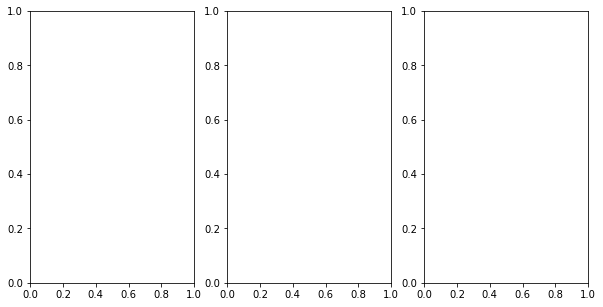

In [14]:
"""
A few examples
"""
for i in train_dataset:
    scan = i[0].unsqueeze(dim = 0) # => [1, 4, 240, 240, 155]
    mask = i[1]

    model.eval()
    layer = 70

    out = model(scan.to(device))

    class_index = torch.argmax(out, dim=1).cpu()
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))    
    axs[0].imshow(scan[layer][0][0][:, :,layer].cpu().detach().numpy(), cmap='gray')
    axs[1].imshow(class_index[0][:, :][layer].cpu().detach().numpy(), cmap='gray')
    axs[2].imshow(mask[:, :][layer].cpu().detach().numpy(), cmap='gray')
    plt.show()

In [15]:
scan.shape

torch.Size([1, 4, 240, 240, 155])

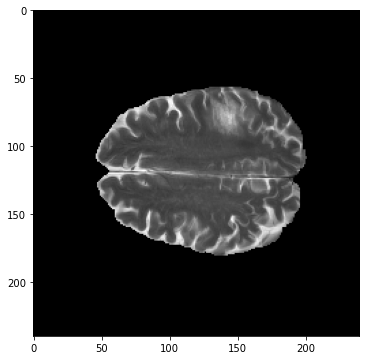

In [16]:
plot_image(scan[0][1][:, :, 100])